# DCGANとは
- Deep Convolutional Generative Adversarial Networks (敵対的生成ネットワーク)の略
- 教師なし学習の一種
- Generator（生成ネットワーク）とDiscriminator（識別ネットワーク）の２つのネットワークで構成される
- Generatorが生成したものをDiscriminatorがその成否を識別する相互学習を行う
    - GeneratorはDiscriminatorを欺くよう最適化される
    - Discriminatorは正確に識別するよう最適化される

<br>

### 贋作家と鑑定士の戦い…
### → ゴールは贋作家の勝利
<img src=http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1524648806/gan_network_eg_jcgooq.jpg alt="Drawing" style="width: 700px;"/>

[DataCamp Tutorial](https://www.datacamp.com/community/tutorials/generative-adversarial-networks)

In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## モデル生成
### Generator

- upsamplingによって、シグナル（noise vector）から画像を生成　→CNNの逆？
- ネットワーク構造：
    1. Dense(FC), 正規化, LeakyReLU -- in(100, ), out(12544, )
    2. Reshape(３次元化) -- out(7, 7, 256)
    3. Conv2DTranspose(Convの逆), 正規化, LeakyReLU -- out(7, 7, 128)
    4. Conv2DTranspose, 正規化, LeakyReLU -- out(14, 14, 64)
    5. Conv2DTranspose, 正規化, Tanh -- out(28, 28, 1)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 出力サイズの確認（noneはバッチサイズ）

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)        

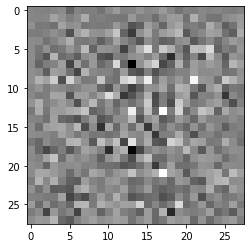

In [ ]:
generator = make_generator_model()
print(generator.summary())

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator

- ネットワーク構造：
    1. Conv2d, LeakyReLU, Dropout -- in(28, 28, 1), out(14, 14, 64)
    2. Conv2d, LeakyReLU, Dropout -- out(7, 7, 128)
    3. Flatten -- out(6273)
    4. FC -- out(1)
- 正しいと判断したデータは正値、偽物と判断したデータは負値を出力する

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
print(discriminator.summary())
decision = discriminator(generated_image)
print ('-'*50, '\n', 'Decision:', decision)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

## Loss and Optimizers

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss

Discriminatorの識別能力のLossを計算する

- 本物に対するDiscriminatorの推定と1行列とのcross entropyを計算
- 同様に偽物（Generator生成画像）に対する推定と0行列とのcross entropyを計算
- 上記合計をTotal lossとする

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator Loss

Generatorの詐欺能力のLossを計算する
- 偽物に対するDiscriminatorの推定（fake_output）と１行列とのcross entropyを計算

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

最適化手法はAdamを採用

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save Checkpoints
- チェックポイント毎に学習パラメータを保存するコードを実装

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

- ランダムなシードを生成して学習開始
- Generatorは渡されたシードから画像を生成し、Discriminatorは本物と偽物に対して識別学習を行う
- Lossを基に各モデルを更新

In [ ]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# コンパイルを行わずともコードを実行できる（よりPythonic）。高速化が図れる
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

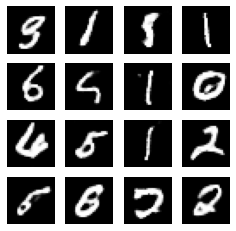

In [ ]:
train(train_dataset, EPOCHS)

## Create a GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

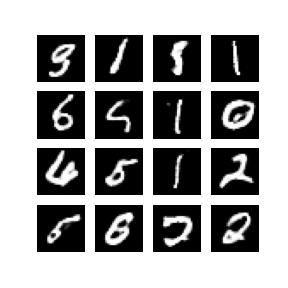

In [ ]:
display_image(200)

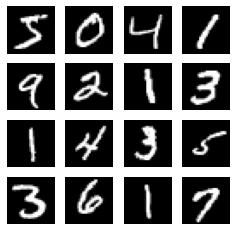

In [ ]:
# 本物と贋作を見比べる
fig = plt.figure(figsize=(4,4))

for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(train_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

Epoch200までの推移<br>
![gan_gif](dcgan_mnist.gif)

# Fashion MNIST

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data() 

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
train_images[0].shape

(28, 28)

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

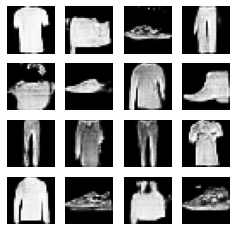

In [ ]:
train(train_dataset, EPOCHS)

Epoch400までの推移<br>
![gan_gif](dcgan_fashion.gif)